In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
import matplotlib.pyplot as plt
import numpy as np
import pylamp.utils.functions as fn
from pylamp.loss.losses import BCELoss, CrossEntropyLoss
from pylamp.neural.sequential import Sequential
from pylamp.neural.layers import Linear, Conv1D, MaxPool1D, Upsampling1D
from pylamp.optim.optimizer import Optim
from pylamp.neural.activations import TanH, Sigmoid, ReLU
from pylamp.optim.optimizer import SGD
from pylamp.utils.usps import load_usps
from pylamp.utils.plotter import Display

## Loading Data

In [140]:
uspsdatatrain = "./data/USPS/USPS_train.txt"
uspsdatatest = "./data/USPS/USPS_test.txt"
X_train, y_train = load_usps(uspsdatatrain)
X_test, y_test = load_usps(uspsdatatest)

## Normalize value between 0 and 1 (targets for BCE)

In [141]:
X_train, X_test = fn.normalize_data(X_train, X_test, minmax=True)

## Autoencoder on USPS data

• Encodage : Linear(256,100) → TanH() → Linear(100,10) → TanH()

• Décodage : Linear(10,100) → TanH() → Linear(100,256) → Sigmoide()

### One big Sequential

In [4]:
autoencoder_linear = Sequential()
encoder_linear = Sequential()
decoder_linear = Sequential()

encoder_linear.add_module(Linear(256,100))
encoder_linear.add_module(TanH())
encoder_linear.add_module(Linear(100,10))
encoder_linear.add_module(TanH())
decoder_linear.add_module(Linear(10,100))
decoder_linear.add_module(TanH())
decoder_linear.add_module(Linear(100,256))
decoder_linear.add_module(Sigmoid())

autoencoder_linear.add_module(encoder_linear)
autoencoder_linear.add_module(decoder_linear)

loss = BCELoss()
optimizer_autoencoder = Optim(autoencoder_linear,loss,1e-3)
autoencoder_losses = SGD(optimizer_autoencoder,X_train, X_train, batch_size=64,epochs=250,verbose=True)

Epoch 1/250, Average Loss: 0.6498312651723106
Epoch 26/250, Average Loss: 0.3954291858787681
Epoch 51/250, Average Loss: 0.3486207370723425
Epoch 76/250, Average Loss: 0.3256124575536224
Epoch 101/250, Average Loss: 0.30985893418888477
Epoch 126/250, Average Loss: 0.2980508599473799
Epoch 151/250, Average Loss: 0.2897268847427431
Epoch 176/250, Average Loss: 0.2836238623439355
Epoch 201/250, Average Loss: 0.2786746944525586
Epoch 226/250, Average Loss: 0.27481116864266814
Training finished.


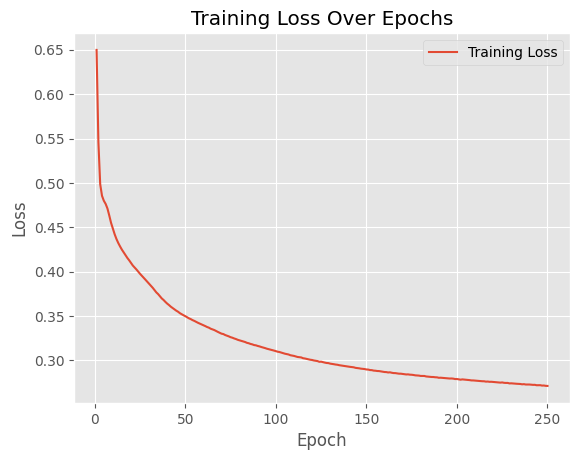

In [5]:
np.save("temp/autoencoder_linear_losses",autoencoder_losses)
Display().plot_loss(autoencoder_losses)

<Figure size 1000x500 with 0 Axes>

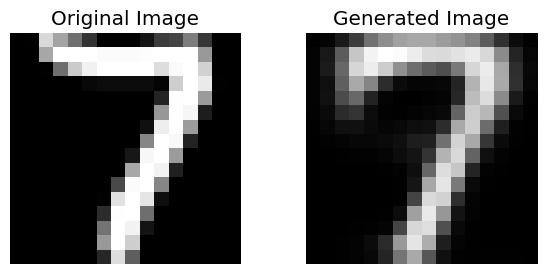

In [120]:
Display().plot_reconstruction(autoencoder_linear, X_test, y_test, n=1)

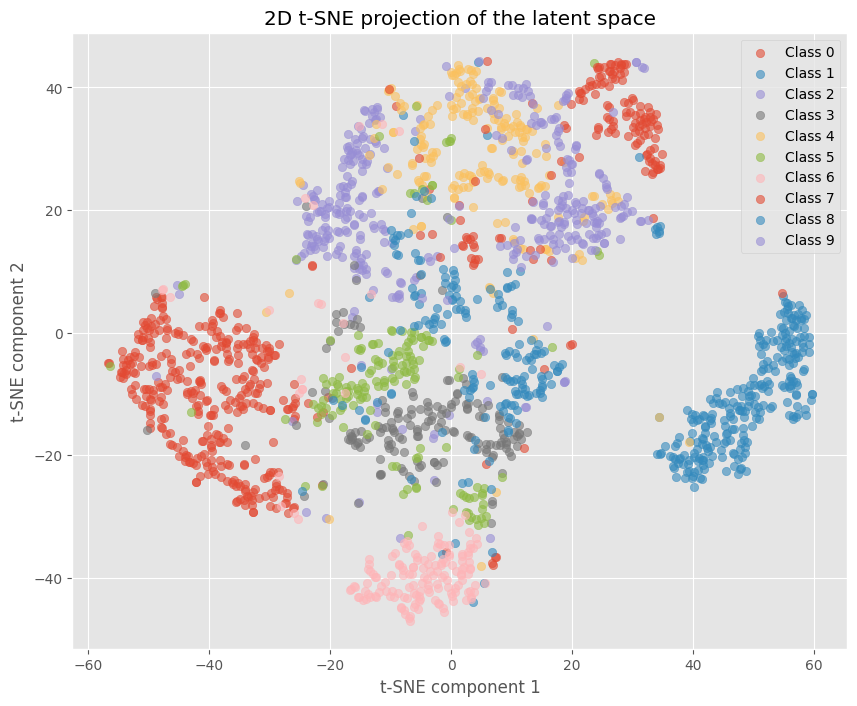

In [95]:
latent_space_lin = Display().plot_latent_space(X_test, y_test, encoder_linear, expand_dims=False)

### Autoencoder with conv

In [142]:
# Define the autoencoder
autoencoder_conv = Sequential()
encoder_conv = Sequential()
decoder_conv = Sequential()
# Define the encoder
encoder_conv.add_module(Conv1D(kernel_size=3, in_channels=1, out_channels=32, strides=1, padding='same'))
encoder_conv.add_module(MaxPool1D(kernel_size=2, strides=2))
encoder_conv.add_module(ReLU())
encoder_conv.add_module(Conv1D(kernel_size=3, in_channels=32, out_channels=16, strides=1, padding='same'))
encoder_conv.add_module(MaxPool1D(kernel_size=2, strides=2))
encoder_conv.add_module(ReLU())
# Define the decoder
decoder_conv.add_module(Upsampling1D(size=2))
decoder_conv.add_module(Conv1D(kernel_size=3, in_channels=16, out_channels=32, strides=1, padding='same'))
decoder_conv.add_module(ReLU())
decoder_conv.add_module(Upsampling1D(size=2))
decoder_conv.add_module(Conv1D(kernel_size=3, in_channels=32, out_channels=1, strides=1, padding='same'))
decoder_conv.add_module(Sigmoid())
# Add the encoder and decoder to the autoencoder
autoencoder_conv.add_module(encoder_conv)
autoencoder_conv.add_module(decoder_conv)

loss = BCELoss()
optimizer_autoencoder_conv = Optim(autoencoder_conv,loss,1e-3)
autoencoder_losses_conv = SGD(optimizer_autoencoder_conv, X_train, X_train, batch_size=64, epochs=20, add_channel_x=True, add_channel_y=True, verbose=True)

Epoch 1/20, Average Loss: 0.5966293393709658
Epoch 3/20, Average Loss: 0.5104065707818668
Epoch 5/20, Average Loss: 0.4485066108400307
Epoch 7/20, Average Loss: 0.38762491978120966
Epoch 9/20, Average Loss: 0.33745025895664277
Epoch 11/20, Average Loss: 0.30349168090110124
Epoch 13/20, Average Loss: 0.28044966573745256
Epoch 15/20, Average Loss: 0.2656185466701728
Epoch 17/20, Average Loss: 0.25651077571928443
Epoch 19/20, Average Loss: 0.25093194796990015
Training finished.


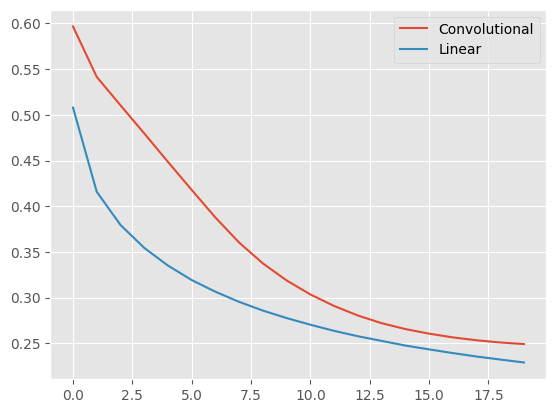

In [144]:
plt.figure()
plt.plot(autoencoder_losses_conv)
plt.plot(autoencoder_losses[:20])
plt.legend(["Convolutional","Linear"])
plt.show()


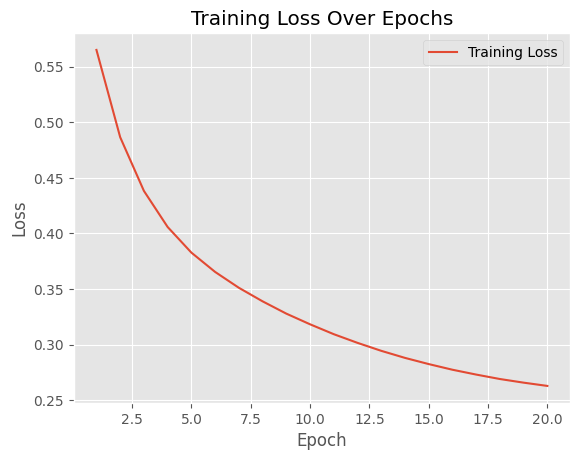

In [9]:
np.save("temp/autoencoder_conv_losses",autoencoder_losses_conv)
Display().plot_loss(autoencoder_losses_conv)

<Figure size 1000x500 with 0 Axes>

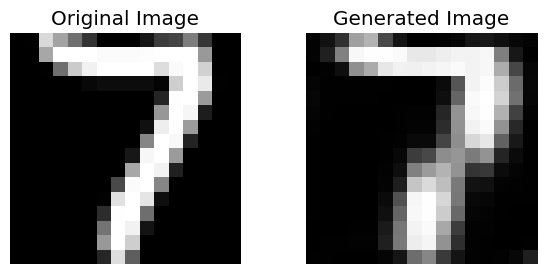

In [148]:
Display().plot_reconstruction(autoencoder_conv, X_test, y_test, expand_dims=True, n=1)

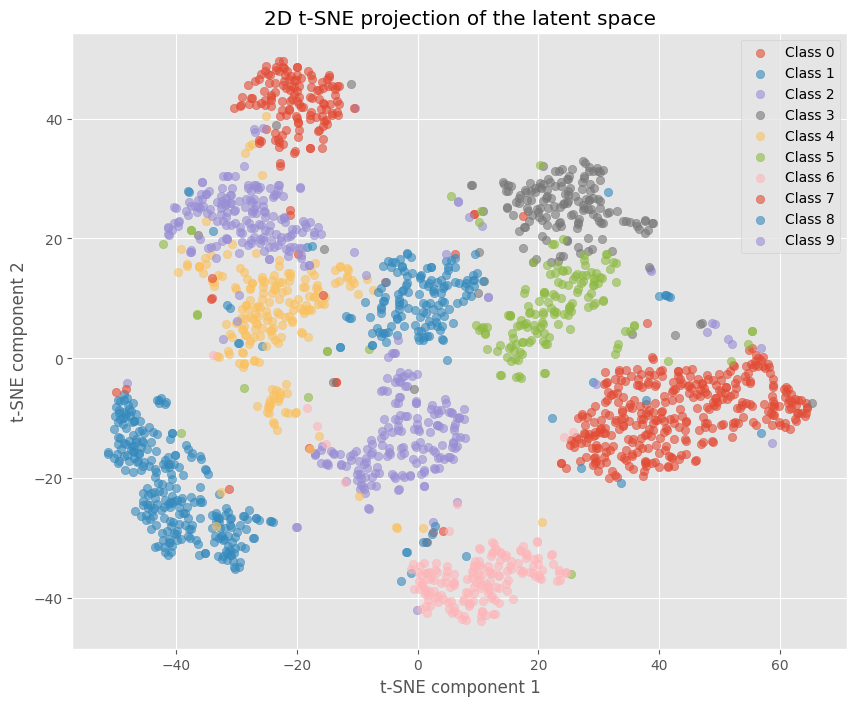

In [149]:
latent_space_conv = Display().plot_latent_space(X_test, y_test, encoder_conv, expand_dims=True)

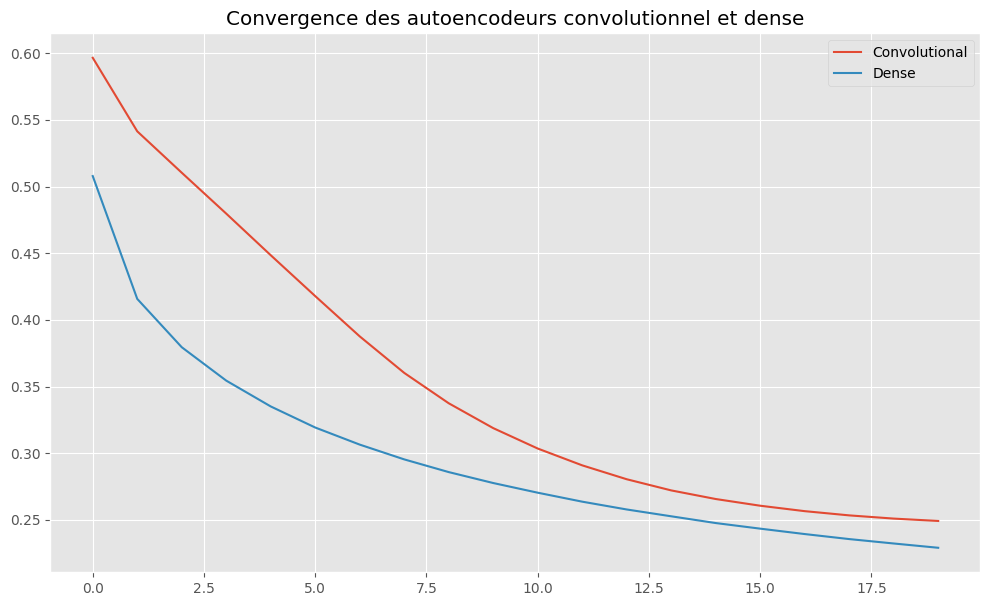

In [291]:
plt.figure(figsize=(12,7))
plt.plot(autoencoder_losses_conv)
plt.plot(autoencoder_losses[:20])
plt.legend(["Convolutional","Dense"])
plt.title("Convergence des autoencodeurs convolutionnel et dense")
plt.show()

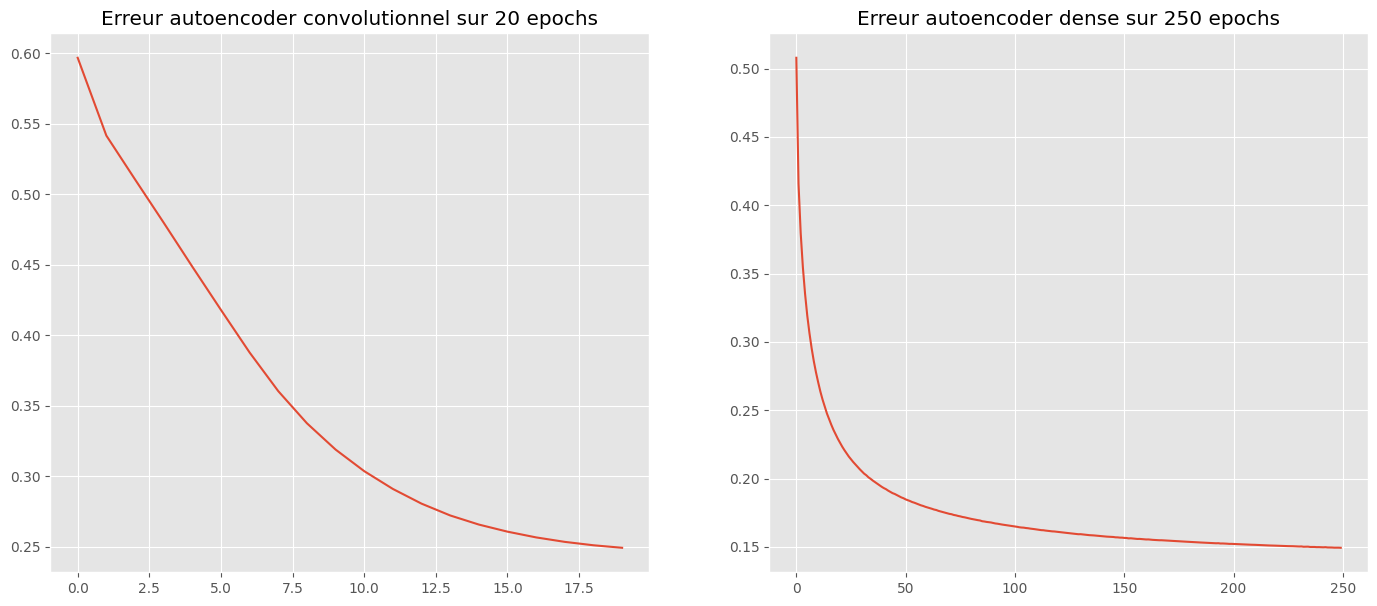

In [290]:
plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.plot(autoencoder_losses_conv)
plt.title("Erreur autoencoder convolutionnel sur 20 epochs")
plt.subplot(1,2,2)
plt.plot(autoencoder_losses)
plt.title("Erreur autoencoder dense sur 250 epochs")
plt.show()

## Comparaison
- L'ARI est supérieur sur les clusters crée sur l'espace latent obtenus a partir des convolutions

In [151]:
fn.cluster_kmeans(latent_space_conv, y_test)
fn.cluster_kmeans(latent_space_lin, y_test)

np.save("temp/latent_space_conv",latent_space_conv)
np.save("temp/latent_space_lin",latent_space_lin)

Adjusted Rand Index: 0.6830
Adjusted Rand Index: 0.5332


In [158]:
from scipy import stats

err_lin = fn.calculate_reconstruction_error(autoencoder_linear, X_test, False)
err_conv = fn.calculate_reconstruction_error(autoencoder_conv, X_test, True)

print("T-test err: ", stats.ttest_rel(err_lin, err_conv))

Average error: 0.047570193776021105
Average error: 0.03662550475671288
T-test err:  TtestResult(statistic=18.4695344590736, pvalue=1.8138611363921445e-70, df=2006)


In [153]:
X_train_latent_conv = encoder_conv.forward(np.expand_dims(X_train, axis=-1))
X_test_latent_conv = encoder_conv.forward(np.expand_dims(X_test, axis=-1))
X_train_latent_lin = encoder_linear.forward(X_train)
X_test_latent_lin = encoder_linear.forward(X_test)

In [154]:
X_train_latent_conv = np.reshape(X_train_latent_conv, (X_train_latent_conv.shape[0], -1))
X_test_latent_conv = np.reshape(X_test_latent_conv, (X_test_latent_conv.shape[0], -1))
print("X_train_latent_conv shape: ", X_train_latent_conv.shape)
print("X_train_latent_lin shape: ", X_train_latent_lin.shape)

X_train_latent_conv shape:  (7291, 1024)
X_train_latent_lin shape:  (7291, 10)


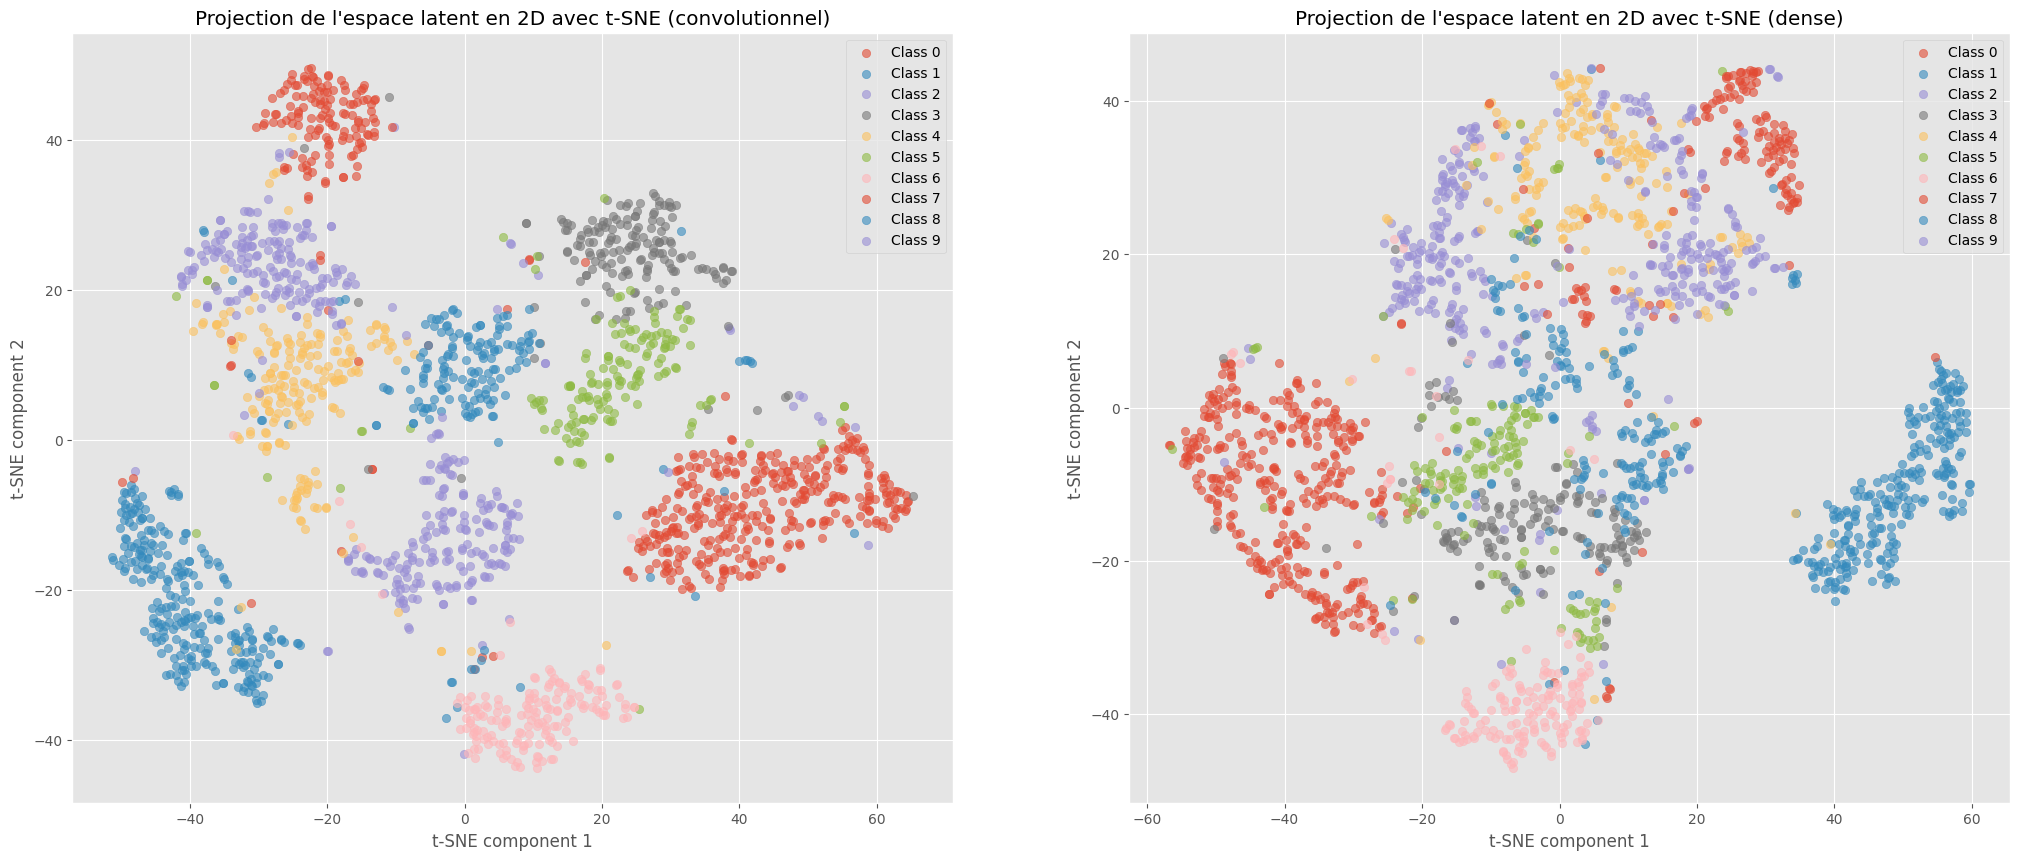

In [289]:
from sklearn.manifold import TSNE

plt.style.use('ggplot')
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
X = np.expand_dims(X_test, axis=-1)
latent_space = encoder_conv.forward(X)
latent_space = latent_space.reshape(latent_space.shape[0], -1)
# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latent_space)
# Assuming y_test contains the labels
y_test_np = np.array(y_test)
# Plot the 2D t-SNE projection
for i in range(10):
    indices = np.where(y_test_np == i)
    plt.scatter(latent_2d[indices, 0], latent_2d[indices, 1], label=f'Class {i}', alpha=0.6)
plt.legend()
plt.title("Projection de l'espace latent en 2D avec t-SNE (convolutionnel)")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.subplot(1, 2, 2)
latent_space = encoder_linear.forward(X_test)
latent_space = latent_space.reshape(latent_space.shape[0], -1)
# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latent_space)
# Assuming y_test contains the labels
y_test_np = np.array(y_test)
# Plot the 2D t-SNE projection
for i in range(10):
    indices = np.where(y_test_np == i)
    plt.scatter(latent_2d[indices, 0], latent_2d[indices, 1], label=f'Class {i}', alpha=0.6)
plt.legend()
plt.title("Projection de l'espace latent en 2D avec t-SNE (dense)")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")


plt.show()

## Classification des données avec latent-space

- On constate que le latent space obtenu avec les convolutions est bien meilleur (après c'est normal il y'a 1024 valeurs)

In [155]:
def train_model(X,y):   

    y = fn.to_one_hot(y,10)
    model = Sequential()
    model.add_module(Linear(X.shape[-1],10))
    model.add_module(TanH())
    model.add_module(Linear(10,10))
    model.add_module(TanH())
    model.add_module(Linear(10,10))
    loss = CrossEntropyLoss()
    optimizer = Optim(model,loss,1e-3)
    model_losses = SGD(optimizer, X, y, batch_size=64,epochs=250,verbose=False)

    return model, model_losses

model_conv, model_losses_conv = train_model(X_train_latent_conv, y_train)
model_lin, model_losses_lin = train_model(X_train_latent_lin, y_train)

Training finished.
Training finished.


In [156]:
fn.print_accuracy(model_conv, X_test_latent_conv, y_test)
fn.print_accuracy(model_lin, X_test_latent_lin, y_test)
print("Model conv losses: ", model_losses_conv[-1])
print("Model lin losses: ", model_losses_lin[-1])

Accuracy = 0.9247633283507724
Accuracy = 0.872446437468859
Model conv losses:  0.03424854102498476
Model lin losses:  0.26907104763849093


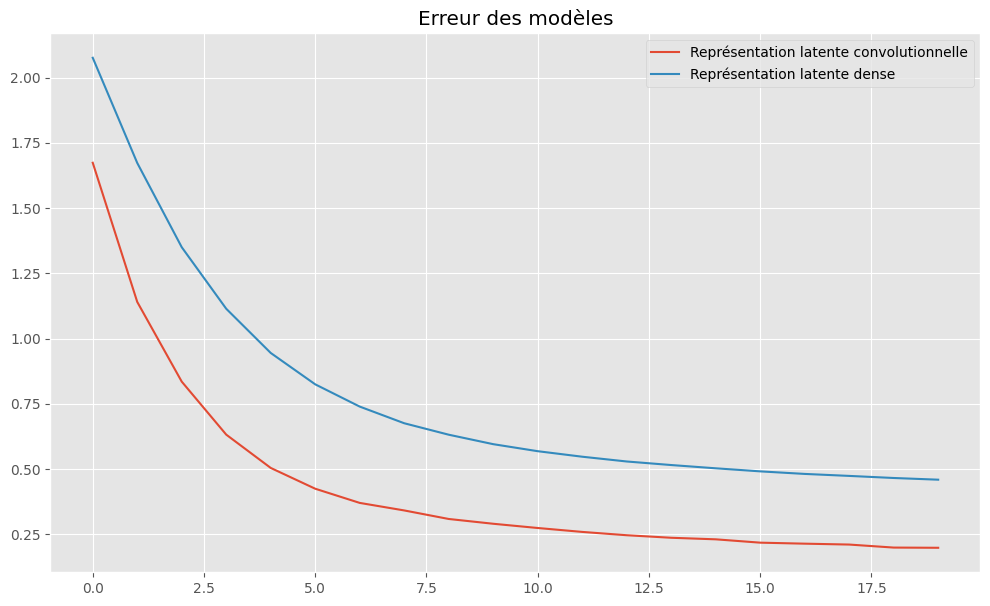

In [292]:
plt.figure(figsize=(12,7))
plt.plot(model_losses_conv[:20])
plt.plot(model_losses_lin[:20])
plt.legend(["Représentation latente convolutionnelle","Représentation latente dense"])
plt.title("Erreur des modèles")
plt.show()

## Variante de la taille du latent space
- Et si nous matchons la même taille avec un lineaire, c'est pareil au niveau des performances ?

In [14]:
autoencoder_linear_inv = Sequential()
encoder_linear_inv = Sequential()
decoder_linear_inv = Sequential()

encoder_linear_inv.add_module(Linear(256,512))
encoder_linear_inv.add_module(TanH())
encoder_linear_inv.add_module(Linear(512,1024))
encoder_linear_inv.add_module(TanH())
decoder_linear_inv.add_module(Linear(1024,512))
decoder_linear_inv.add_module(TanH())
decoder_linear_inv.add_module(Linear(512,256))
decoder_linear_inv.add_module(Sigmoid())

autoencoder_linear_inv.add_module(encoder_linear_inv)
autoencoder_linear_inv.add_module(decoder_linear_inv)

loss = BCELoss()
optimizer_autoencoder = Optim(autoencoder_linear_inv,loss,1e-3)
autoencoder_losses = SGD(optimizer_autoencoder,X_train, X_train, batch_size=64,epochs=250,verbose=True)

Epoch 1/250, Average Loss: 0.507892234327819
Epoch 26/250, Average Loss: 0.2140899685425621
Epoch 51/250, Average Loss: 0.18474537661431248
Epoch 76/250, Average Loss: 0.1723068638983993
Epoch 101/250, Average Loss: 0.16492121048508937
Epoch 126/250, Average Loss: 0.1600626771278942
Epoch 151/250, Average Loss: 0.15655781666244922
Epoch 176/250, Average Loss: 0.15405149429761295
Epoch 201/250, Average Loss: 0.15213190912986246
Epoch 226/250, Average Loss: 0.1505391629968253
Training finished.


<Figure size 1000x500 with 0 Axes>

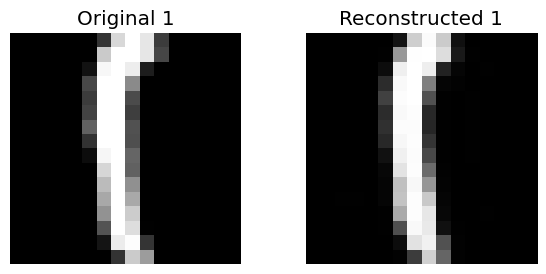

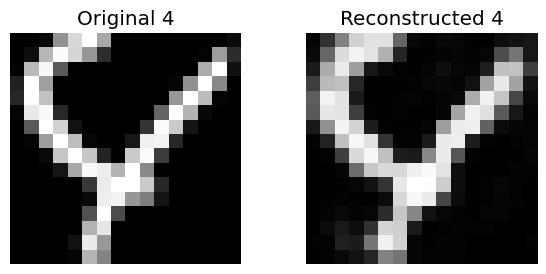

Average error: 0.006931256559838188


In [92]:
Display().plot_reconstruction(autoencoder_linear_inv, X_test, y_test, n=2)

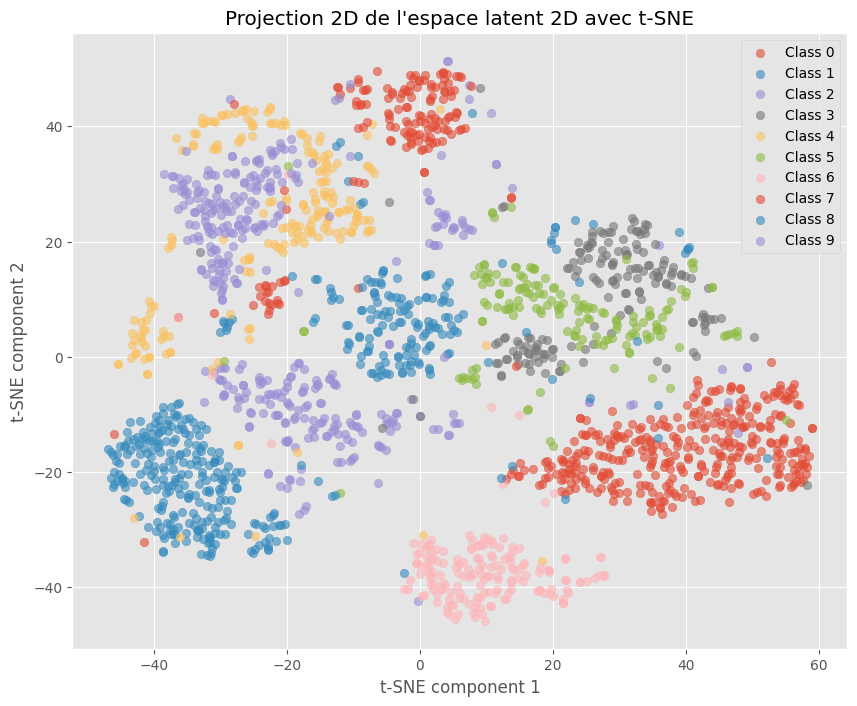

Adjusted Rand Index: 0.5571


In [180]:
latent_space_lin_inv = Display().plot_latent_space(X_test, y_test, encoder_linear_inv)
fn.cluster_kmeans(latent_space_lin_inv, y_test)
np.save("temp/latent_space_lin_inv",latent_space_lin)

In [310]:
X_train_latent_lin_inv = encoder_linear_inv.forward(X_train)
X_test_latent_lin_inv = encoder_linear_inv.forward(X_test)

model_lin_inv, model_losses_lin_inv = train_model(X_train_latent_lin_inv, y_train)

Training finished.


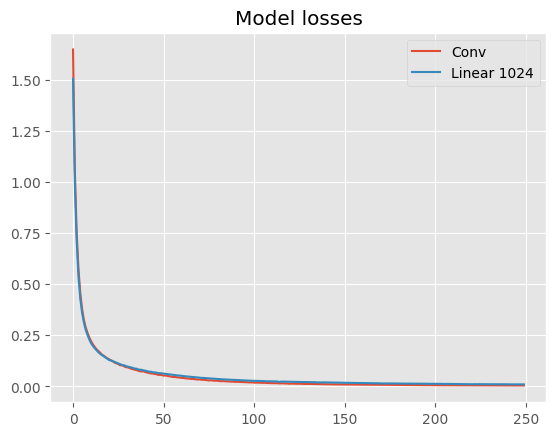

In [315]:
plt.figure()
plt.plot(model_losses_conv)
plt.plot(model_losses_lin_inv)
plt.legend(["Conv","Linear 1024"])
plt.title("Model losses")
plt.show()

In [316]:
fn.print_accuracy(model_lin_inv, X_test_latent_lin_inv, y_test)
print("Model lin losses: ", model_losses_lin_inv[-1])

Accuracy = 0.9162929745889388
Model lin losses:  0.00956088953007035


## T-test pour voir si y'a bien une différence entre les deux

Différence significative entre les loss, et accuracy

- Mean loss conv:  0.004266478439559869
- Mean loss inv:  0.009530081017576601
- Mean acc conv:  0.9260587942202292
- Mean acc inv:  0.9090682610861984
- T-test loss:  TtestResult(statistic=-16.726988712719947, pvalue=4.363641187061356e-08, df=9)
- T-test acc:  TtestResult(statistic=7.309194194389724, pvalue=4.519935070892253e-05, df=9)

In [326]:
from scipy import stats

def t_test(nb_train=5):
    loss_conv, loss_inv = [], []
    acc_conv, acc_inv = [], []
    for i in range(nb_train):
        print("Train: ", i)
        model_lin_inv_temp, model_losses_lin_inv_temp = train_model(X_train_latent_lin_inv, y_train)
        model_conv_temp, model_losses_conv_temp = train_model(X_train_latent_conv, y_train)
        acc_inv.append(fn.print_accuracy(model_lin_inv_temp, X_test_latent_lin_inv, y_test, print_result=False))
        acc_conv.append(fn.print_accuracy(model_conv_temp, X_test_latent_conv, y_test, print_result=False))
        loss_inv.append(model_losses_lin_inv_temp[-1])
        loss_conv.append(model_losses_conv_temp[-1])
    print("Mean loss conv: ", np.mean(loss_conv))
    print("Mean loss inv: ", np.mean(loss_inv))
    print("Mean acc conv: ", np.mean(acc_conv))
    print("Mean acc inv: ", np.mean(acc_inv))
    print("T-test loss: ", stats.ttest_rel(loss_conv, loss_inv))
    print("T-test acc: ", stats.ttest_rel(acc_conv, acc_inv))

    return loss_conv, loss_inv, acc_conv, acc_inv

loss_conv, loss_inv, acc_conv, acc_inv = t_test(10)

Training finished.
Training finished.
Mean loss conv:  0.004266478439559869
Mean loss inv:  0.009530081017576601
Mean acc conv:  0.9260587942202292
Mean acc inv:  0.9090682610861984
T-test loss:  TtestResult(statistic=-16.726988712719947, pvalue=4.363641187061356e-08, df=9)
T-test acc:  TtestResult(statistic=7.309194194389724, pvalue=4.519935070892253e-05, df=9)


In [327]:
np.save("temp/loss_conv",loss_conv)
np.save("temp/loss_inv",loss_inv)
np.save("temp/acc_conv",acc_conv)
np.save("temp/acc_inv",acc_inv)

## Capacité de debruitage des modèles

In [238]:
def gaussian_noise(X, mean=0, std=1):
    noise = np.random.normal(mean, std, X.shape)
    return X + noise

def salt_and_pepper(X, prob=0.3):
    X_noisy = X.copy()
    for i in range(X.shape[0]):
        mask = np.random.choice([0, 1], size=X.shape[1], p=[prob, 1 - prob])
        X_noisy[i] = X_noisy[i] * mask
    return X_noisy


X_test_noisy = gaussian_noise(X_test, std=0.1)
X_test_pepper = salt_and_pepper(X_test, prob=0.1)
X_test_noisy = np.clip(X_test_noisy, 0, 1)
X_test_pepper = np.clip(X_test_pepper, 0, 1)

<Figure size 1000x500 with 0 Axes>

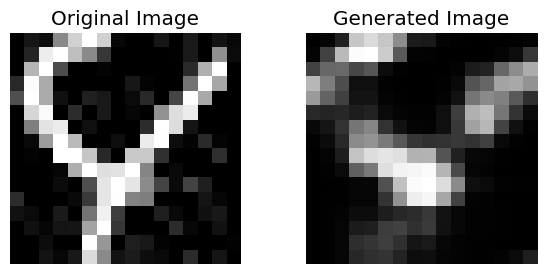

In [270]:
Display().plot_reconstruction(autoencoder_conv, X_test_noisy, y_test, expand_dims=True, n=1)

<Figure size 1000x500 with 0 Axes>

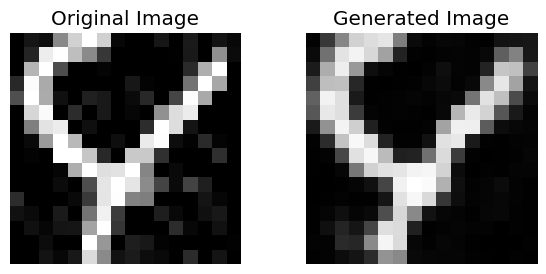

In [269]:
Display().plot_reconstruction(autoencoder_linear_inv, X_test_noisy, y_test, expand_dims=False, n=1)

<Figure size 1000x500 with 0 Axes>

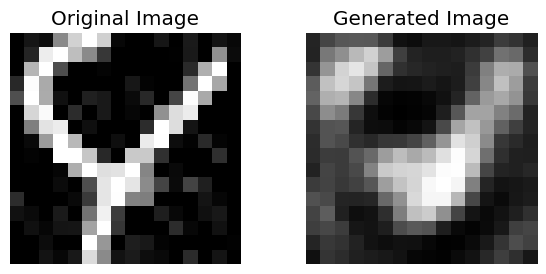

In [256]:
Display().plot_reconstruction(autoencoder_linear, X_test_noisy, y_test, expand_dims=False, n=1)

<Figure size 1000x500 with 0 Axes>

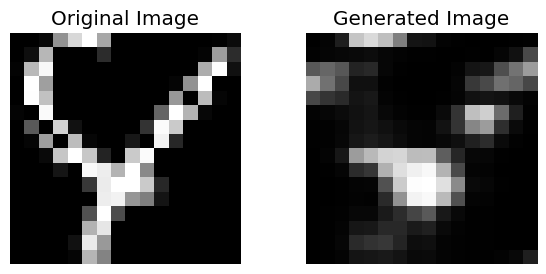

In [277]:
Display().plot_reconstruction(autoencoder_conv, X_test_pepper, y_test, expand_dims=True, n=1)

<Figure size 1000x500 with 0 Axes>

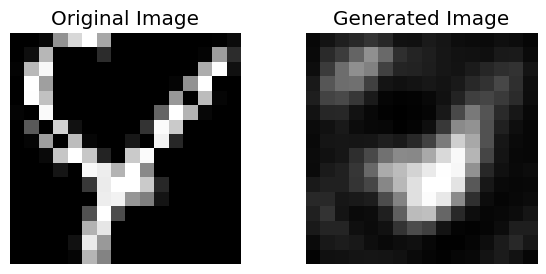

In [280]:
Display().plot_reconstruction(autoencoder_linear, X_test_pepper, y_test, expand_dims=False, n=1)

<Figure size 1000x500 with 0 Axes>

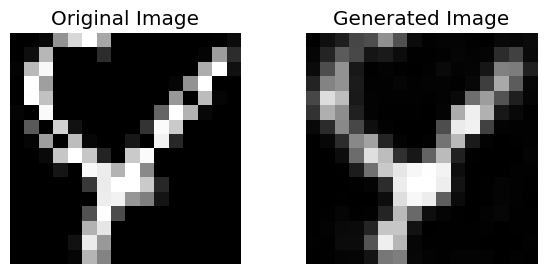

In [283]:
Display().plot_reconstruction(autoencoder_linear_inv, X_test_pepper, y_test, expand_dims=False, n=1)